In [1]:
import fitz  # PyMuPDF
import os
import glob

# Define the directories
pdf_dir = "../../data/pdf/"
txt_path = "../../data/txt/pdf_contents.txt"

# Create output directory if it doesn't exist
os.makedirs(os.path.dirname(txt_path), exist_ok=True)

# Get a list of all PDF files in the directory
pdf_files = glob.glob(os.path.join(pdf_dir, "*.pdf"))

# Initialize a variable to hold the combined content
combined_content = ""

# Loop through all PDF files
for pdf_file in pdf_files:
    # Open the PDF document
    pdf_document = fitz.open(pdf_file)
    
    # Extract text from each page of the PDF
    content = ""
    for page_number in range(pdf_document.page_count):
        page = pdf_document[page_number]
        content += page.get_text()
    
    # Close the PDF document
    pdf_document.close()
    
    # Add a header for each PDF (optional)
    combined_content += f"--- Contents of {os.path.basename(pdf_file)} ---\n"
    combined_content += content.strip() + "\n\n"

# Write the combined content to the text file
with open(txt_path, "w", encoding="utf-8") as txt_file:
    txt_file.write(combined_content)

print(f"Combined PDF contents saved to {txt_path}")

Combined PDF contents saved to ../../data/txt/pdf_contents.txt


In [3]:
import os
import string
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# Define additional stop words
ADDITIONAL_STOPWORDS = {"bank", "fdic"}

def clean_text(file_path, output_path):
    # Ensure NLTK resources are downloaded
    try:
        stop_words = set(stopwords.words('english'))
    except LookupError:
        import nltk
        nltk.download('stopwords')
        nltk.download('punkt')
        stop_words = set(stopwords.words('english'))

    stop_words.update(ADDITIONAL_STOPWORDS)

    # Prepare punctuation to exclude periods
    punctuation_to_remove = string.punctuation.replace('.', '')

    # Initialize the stemmer
    stemmer = PorterStemmer()

    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    cleaned_lines = []

    for line in lines:
        # Remove numbers from the line
        line = re.sub(r'\d+', '', line)
        # Tokenize line
        tokens = word_tokenize(line)
        # Filter and process tokens
        tokens = [
            stemmer.stem(token.lower()) for token in tokens
            if token.lower() not in stop_words
            and token not in punctuation_to_remove
            and len(token) > 1
        ]
        # Reconstruct cleaned sentence
        cleaned_line = ' '.join(tokens)
        cleaned_lines.append(cleaned_line)

    # Save cleaned content to a new file
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    with open(output_path, 'w', encoding='utf-8') as output_file:
        output_file.write('\n'.join(cleaned_lines))

    print(f"Cleaned text saved to {output_path}")

# File paths
input_file_path = '../../data/txt/pdf_contents.txt'
output_file_path = '../../data/txt/cleaned_contents.txt'

# Run the function
clean_text(input_file_path, output_file_path)

Cleaned text saved to ../../data/txt/cleaned_contents.txt


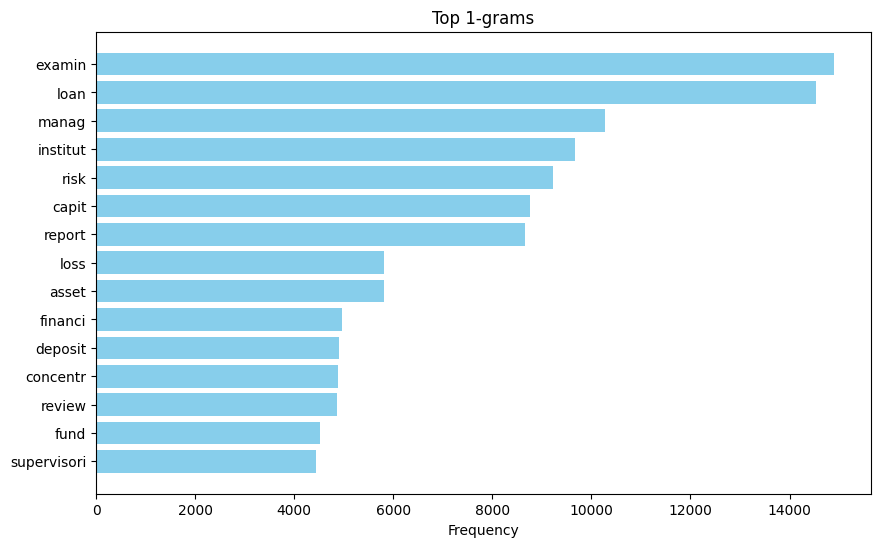

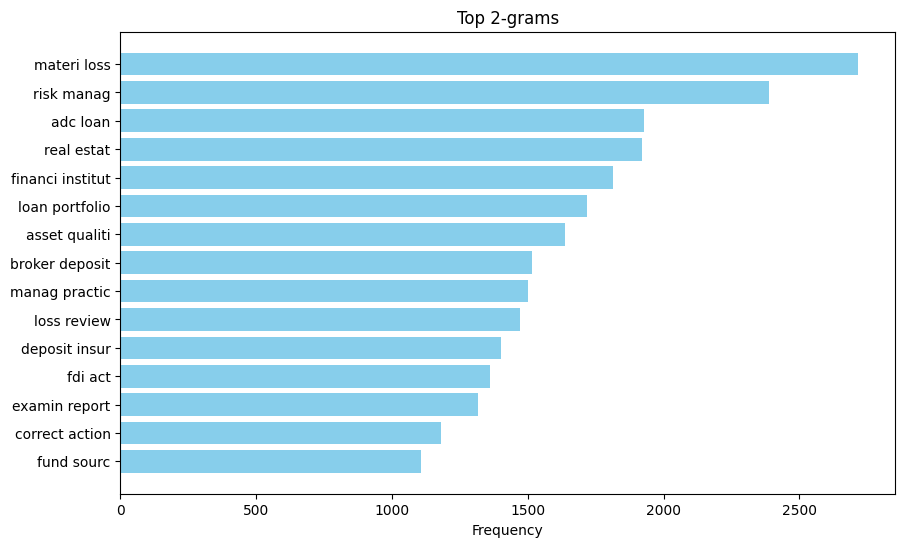

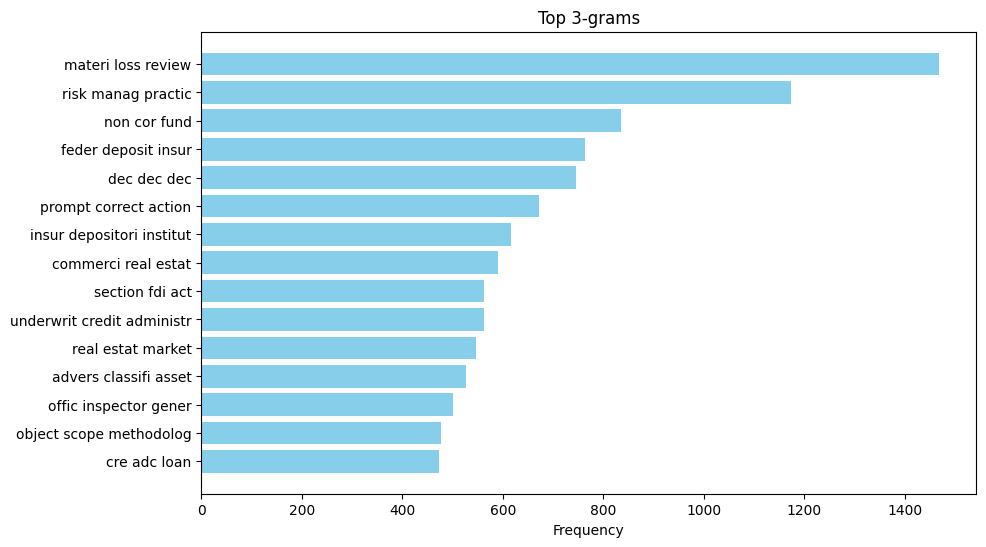

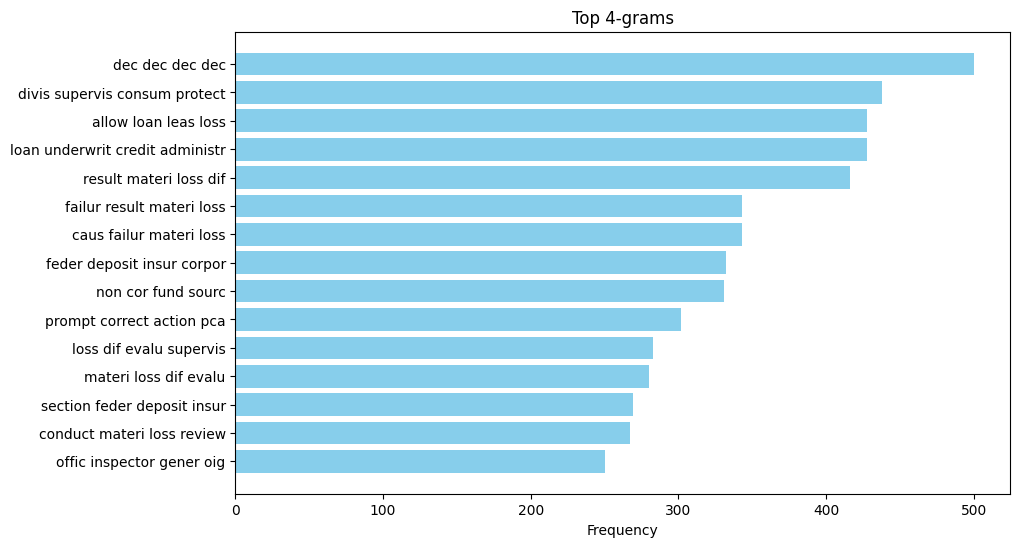

In [4]:
import re
from collections import Counter
from nltk import ngrams
import matplotlib.pyplot as plt

def read_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read()

def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'\W+', ' ', text)  # Remove punctuation
    text = text.strip()  # Remove leading/trailing spaces
    return text

def get_ngrams(text, n):
    words = text.split()
    return list(ngrams(words, n))

def visualize_ngrams(ngrams_freq, title, top_n=10):
    top_ngrams = ngrams_freq.most_common(top_n)
    labels, counts = zip(*top_ngrams)
    labels = [' '.join(label) for label in labels]  # Join n-grams with spaces
    
    plt.figure(figsize=(10, 6))
    plt.barh(labels, counts, color='skyblue')
    plt.xlabel('Frequency')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

# File path
file_path = '../../data/txt/cleaned_contents.txt'  # Replace with your file path

# Main processing
text = preprocess_text(read_file(file_path))

# N-gram extraction
for n in range(1, 5):  # Unigrams to Qualgrams
    ngrams_list = get_ngrams(text, n)
    ngrams_freq = Counter(ngrams_list)
    visualize_ngrams(ngrams_freq, f'Top {n}-grams', top_n=15)

In [7]:
import os
import re
import nltk
import gensim
from gensim import corpora
from gensim.models import LdaModel
from nltk.tokenize import word_tokenize
from gensim.models.coherencemodel import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim_models
from IPython.display import display
import pyLDAvis.gensim_models as gensimvis

# Ensure NLTK dependencies are available
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dd\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dd\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dd\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
def preprocess_for_lda(input_file_path):
    """
    Preprocess the cleaned text for LDA modeling by tokenizing and creating a document-term matrix.
    """
    # Read the cleaned text file
    with open(input_file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    # Tokenize the text into words
    processed_lines = [word_tokenize(line.strip()) for line in lines if line.strip()]

    return processed_lines

In [9]:
# File path to the cleaned text
input_file_path = '../../data/txt/cleaned_contents.txt'

# Preprocess text
processed_lines = preprocess_for_lda(input_file_path)

In [20]:
# Create a dictionary representation of the documents
dictionary = corpora.Dictionary(processed_lines)

# Create a document-term matrix
corpus = [dictionary.doc2bow(text) for text in processed_lines]

# Perform LDA topic modeling
lda_model = LdaModel(
    corpus=corpus,
    num_topics=4,
    id2word=dictionary,
    passes=10,
    random_state=493
)

In [21]:
# Print the topics
topics = lda_model.print_topics(num_words=7)  # num_words shows top words in each topic
for topic in topics:
    print(topic)

(0, '0.030*"first" + 0.028*"deposit" + 0.027*"republ" + 0.020*"fund" + 0.017*"capit" + 0.012*"//" + 0.011*"sourc"')
(1, '0.034*"review" + 0.029*"action" + 0.026*"report" + 0.024*"loss" + 0.021*"institut" + 0.020*"requir" + 0.018*"materi"')
(2, '0.053*"examin" + 0.044*"manag" + 0.031*"risk" + 0.024*"rate" + 0.016*"board" + 0.016*"recommend" + 0.016*"supervisori"')
(3, '0.065*"loan" + 0.020*"credit" + 0.018*"asset" + 0.017*"concentr" + 0.015*"market" + 0.014*"lend" + 0.013*"capit"')


In [22]:
def compute_coherence_scores(processed_lines, start=2, limit=6):
    """Compute coherence scores for various numbers of topics."""
    coherence_scores = []
    for num_topics in range(start, limit + 1):
        lda_model = gensim.models.LdaModel(
            corpus,
            num_topics=num_topics,
            id2word=dictionary,
            passes=10,
            random_state=493
        )
        coherence_model = CoherenceModel(model=lda_model, texts=processed_lines, dictionary=dictionary, coherence='c_v')
        coherence_score = coherence_model.get_coherence()
        coherence_scores.append((num_topics, coherence_score))
        print(f"Number of Topics: {num_topics}, Coherence Score: {coherence_score}")

    return coherence_scores

In [23]:
# Compute coherence scores
coherence_scores = compute_coherence_scores(processed_lines, start=2, limit=6)

Number of Topics: 2, Coherence Score: 0.33025981711223235
Number of Topics: 3, Coherence Score: 0.3758918586841262
Number of Topics: 4, Coherence Score: 0.3830323980964869
Number of Topics: 5, Coherence Score: 0.36628751460780523
Number of Topics: 6, Coherence Score: 0.3765495893819181


In [24]:
def plot_coherence_scores(coherence_scores):
    """Plot coherence scores for different numbers of topics."""
    num_topics = [score[0] for score in coherence_scores]
    scores = [score[1] for score in coherence_scores]

    plt.figure(figsize=(8, 5))
    plt.plot(num_topics, scores, marker='o', linestyle='--', color='b')
    plt.title('Coherence Scores by Number of Topics')
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence Score')
    plt.grid()
    plt.show()

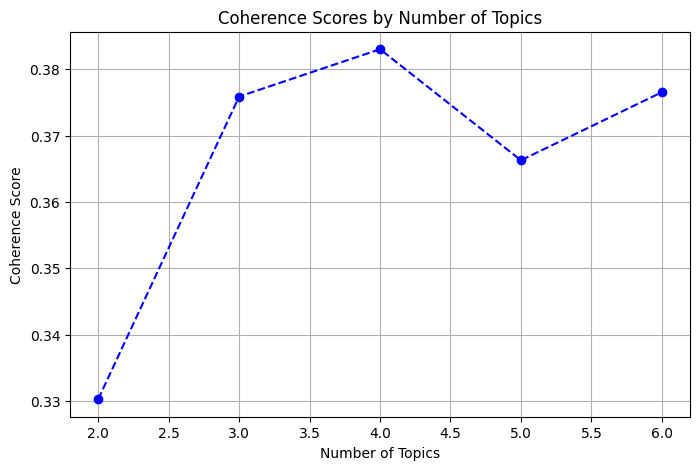

In [25]:
# Plot coherence scores
plot_coherence_scores(coherence_scores)

In [26]:
pyLDAvis.enable_notebook()
gensimvis.prepare(lda_model, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.076711  0.135519       1        1  30.604801
1     -0.327149 -0.053350       2        1  24.404643
3      0.219364  0.232376       3        1  23.430425
0      0.184497 -0.314545       4        1  21.560131, topic_info=       Term          Freq         Total Category  logprob  loglift
29     loan  11162.000000  11162.000000  Default  30.0000  30.0000
57   examin  11954.000000  11954.000000  Default  29.0000  29.0000
22    manag   9898.000000   9898.000000  Default  28.0000  28.0000
10   review   6195.000000   6195.000000  Default  27.0000  27.0000
54   action   5184.000000   5184.000000  Default  26.0000  26.0000
..      ...           ...           ...      ...      ...      ...
64     plan   1112.311166   2488.589008   Topic4  -4.9607   0.7290
16    asset   1336.811570   5469.600995   Topic4  -4.7768   0.1254
43   liquid    992.636779   3086.290299   Topic4  -5.0745   0.4000
235   total    925.737332   2352.016094   Topic4  -5.1443   0.6019
81   includ    898.864354   4340.299642   Topic4  -5.1738  -0.0402

[202 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0         2  0.999116          --
645       4  0.999701          //
839       4  0.999085     account
225       2  0.999416         act
54        2  0.999815      action
...     ...       ...         ...
235       4  0.393705       total
806       3  0.999110  undercapit
2191      4  0.998634     uninsur
382       3  0.999277        valu
391       1  0.999245       visit

[207 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 4, 1])